In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve


In [67]:
# 读取数据
pdData = pd.read_csv('ex2data1.txt', header=None, names=['Exam 1', 'Exam 2', 'Admitted'])


Text(0, 0.5, 'Exam 2 Score')

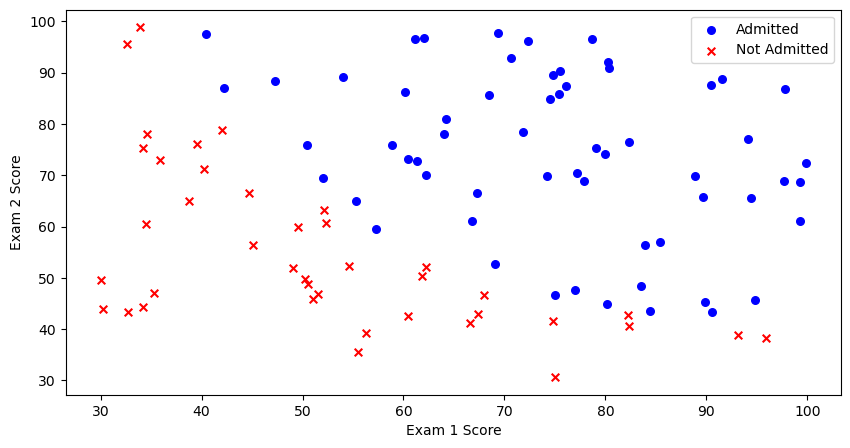

In [68]:
# 可视化数据
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

In [69]:
# sigmoid函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [70]:
# 计算损失函数和梯度
def compute_cost_and_gradient(X, y, W):
    m = X.shape[0]
    P = sigmoid(np.dot(X, W))
    loss = np.sum(-y * np.log(P) - (1 - y) * np.log(1 - P)) / m
    gradient = np.dot(X.T, (P - y)) / m
    return loss, gradient

In [71]:
# 定义逻辑回归模型的训练过程
def logistic_regression(X_train, y_train, X_test, y_test, alpha, iters):
    feature_dim = X_train.shape[1]
    W = np.zeros((feature_dim, 1))
    train_loss_history = []
    test_loss_history = []
    for i in range(iters):
        train_loss, gradient = compute_cost_and_gradient(X_train, y_train, W)
        test_loss, _ = compute_cost_and_gradient(X_test, y_test, W)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        W -= alpha * gradient
    return train_loss_history, test_loss_history, W

In [72]:
# 定义模型评价函数
def evaluate_model(X_test, y_test, W):
    y_pred = (sigmoid(np.dot(X_test, W)) >= 0.5).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, sigmoid(np.dot(X_test, W)))
    fpr, tpr, thresholds = roc_curve(y_test, sigmoid(np.dot(X_test, W)))
    return precision, recall, f1, auc, fpr, tpr

In [73]:
# 数据归一化
def normalize_data(data):
    normalized_data = (data - data.min()) / (data.max() - data.min())
    return normalized_data

In [74]:
# 将特征值归一化
pdData[['Exam 1', 'Exam 2']] = normalize_data(pdData[['Exam 1', 'Exam 2']])

In [75]:
# K折交叉验证
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
alpha = 0.005
iters = 100000
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []
fpr_list = []
tpr_list = []
train_loss_list = []
test_loss_list = []

for train_index, test_index in k_fold.split(pdData):
    X_train, X_test = pdData.iloc[train_index][['Exam 1', 'Exam 2']].values, pdData.iloc[test_index][
        ['Exam 1', 'Exam 2']].values
    y_train, y_test = pdData.iloc[train_index]['Admitted'].values, pdData.iloc[test_index]['Admitted'].values

    # 添加偏置项
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # 训练模型
    train_loss_history, test_loss_history, W = logistic_regression(X_train, y_train.reshape(-1, 1), X_test, y_test.reshape(-1, 1), alpha, iters)

    # 模型评价
    precision, recall, f1, auc, fpr, tpr = evaluate_model(X_test, y_test, W)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_scores.append(auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    train_loss_list.append(train_loss_history)
    test_loss_list.append(test_loss_history)

In [76]:
# 打印评价结果
print("Precision:", np.mean(precision_scores))
print("Recall:", np.mean(recall_scores))
print("F1 Score:", np.mean(f1_scores))
print("AUC:", np.mean(auc_scores))

Precision: 0.9056277056277058
Recall: 0.9175324675324674
F1 Score: 0.9096494487798836
AUC: 0.9691287878787879


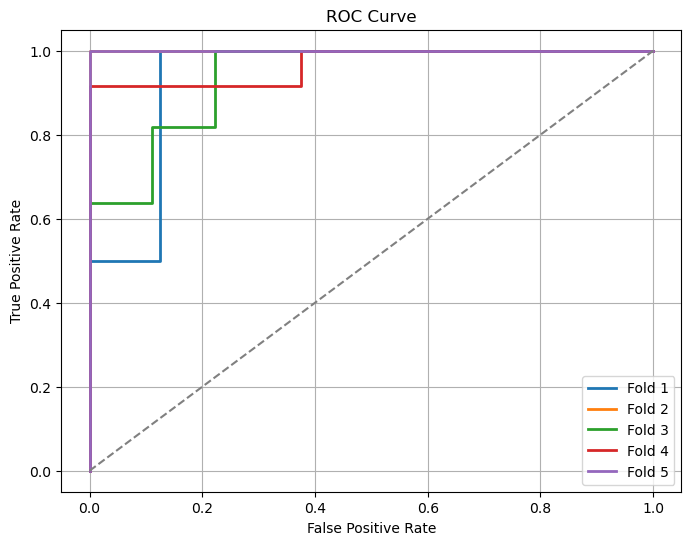

In [77]:
# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list)):
    label = f'Fold {i+1}'
    plt.plot(fpr, tpr, linestyle='-', linewidth=2, label=label)  # 添加标签
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()  # 添加图例
plt.grid(True)
plt.show()

In [78]:
# 计算平均训练集和验证集的损失
train_loss_avg = np.mean(train_loss_list, axis=0)
test_loss_avg = np.mean(test_loss_list, axis=0)

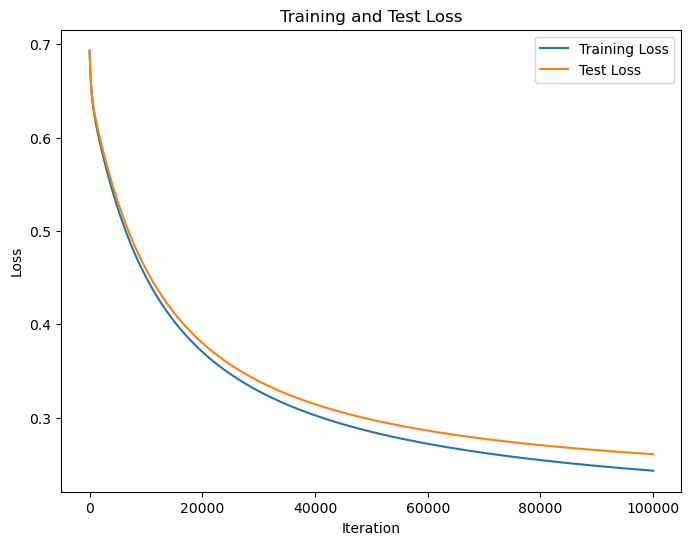

In [79]:
# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(8, 6))
plt.plot(train_loss_avg, label='Training Loss')
plt.plot(test_loss_avg, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()